Rotating centroids of LM plane into EM warped stack

In [1]:
import numpy as np
import tifffile

#Image processing
from skimage import transform, measure, feature
from skimage.exposure import match_histograms, equalize_adapthist
from skimage.transform import SimilarityTransform, EuclideanTransform
from skimage.segmentation import expand_labels # expand EM warped labels
from skimage.filters import difference_of_gaussians

from warp_stack_to_plane import warp_stack_to_plane

#Visualization
import matplotlib.pyplot as plt
import napari
from scipy import ndimage
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec



C:\ProgramData\mambaforge\envs\fishpy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Utils functions (image processing)

def bin_2x2_grayscale(image):
    ''' Bin image in xy 2 by 2'''
    # Ensure the height and width are divisible by 2
    h, w = image.shape
    h = h // 2 * 2
    w = w // 2 * 2
    image = image[:h, :w]

    # Reshape and calculate the mean along the new axes
    binned_image = image.reshape(h//2, 2, w//2, 2).mean(axis=(1, 3))
    return binned_image

def slice_into_uniform_tiles(image, nx, ny, plot=True):
    """
    Slice an image into uniformly sized tiles.
    
    Parameters:
    - image: 2D NumPy array representing the image to be sliced.
    - nx: Number of tiles along the x-axis (width).
    - ny: Number of tiles along the y-axis (height).
    - plot: Boolean if the tiles should be ploted.
    
    Returns:
    - A 2D NumPy array with desired shape, each space representing a uniformly sized tile.
    """
    height, width = image.shape
    print(f"Original image size: {height}x{width}")
    
    # Calculate the size of each tile
    M, N = (height // ny, width // nx)
    print(f"Tile size: {M}x{N}")
    
    # Adjust the height and width to ensure all tiles are of equal size
    adjusted_height = M * ny
    adjusted_width = N * nx
    print(f"Adjusted image size for perfect slicing: {adjusted_height}x{adjusted_width}")
    
    # Adjust image size for slicing
    adjusted_image = image[:adjusted_height, :adjusted_width]
    
    # Generate perfectly sized tiles
    tiles = np.array([adjusted_image[x:x+M, y:y+N] for x in range(0, adjusted_height, M) for y in range(0, adjusted_width, N)])
    
    print(f"Number of tiles: {len(tiles)}")

    reshaped_tiles = tiles.reshape(ny,nx, tiles.shape[1],tiles.shape[2])

    if plot:
        fig, axs = plt.subplots(ncols= nx, nrows= ny)
    
        count=0
        for i in range(ny):
            for j in range(nx):
                axs[i,j].imshow(reshaped_tiles[i,j])
                #axs[i,j].imshow(reshaped_tiles[i,j].astype(np.uint16))
                count+=1
        plt.show()
    
    return reshaped_tiles, (M,N), (adjusted_height, adjusted_width)

# Example usage:
# Assuming `plane` is your 2D numpy array representing the image
# plane = np.random.rand(100, 100) # Example initialization, replace with your actual image
# nx, ny = (3, 3)  # Desired number of tiles in each dimension
# tiles = slice_into_uniform_tiles(plane, nx, ny)
# This will print out the details and return the list of tiles.

# adding columns to stacks
def extend_stack(stack, blank=100):
    extended_stack = np.zeros(shape=(stack.shape[0],stack.shape[1]+2*blank,stack.shape[2]+2*blank)) 
    extended_stack[:,blank:-blank,blank:-blank] = stack#.astype(np.uint16)
    return extended_stack

In [3]:
def find_plane_in_stack(plane, stack, reshape=True, plot_all_correlations=False, z_range=None):
    """
    Correlate a given plane with slices in a 3D stack.
    If an angle is provided, the stack is rotated before correlation along the plane given.
    
    Parameters:
    - stack: 3D stack where the plane is to be searched.
    - plane: The 2D plane to be matched.

    Returns:
    - (max_corr, max_position): Tuple containing the position of the best match and its coordinates.
    """

    max_corr = -np.inf
    max_position = None
    

    all_correlations = []

    slices = [*range(stack.shape[0])] if z_range == None else [*range(z_range[0],z_range[-1])]

        
    # Loop through each slice in the stack (or rotated stack)
    for slice in slices:
        corr = feature.match_template(stack[slice], plane, pad_input=True)
        max_value = np.max(corr)
        position = np.unravel_index(np.argmax(corr), corr.shape)
        all_correlations.append(max_value)
        
        if max_value > max_corr:
            max_corr = max_value
            max_position = (slice, *position)
    
    if plot_all_correlations:
        plt.scatter(slices, all_correlations)
        plt.xlabel('Slice')
        plt.ylabel('Correlation')
        plt.title('Correlation of Each Slice')
        plt.show()
        
    return (max_corr, max_position, all_correlations)

def crop_stack_to_matched_plane(stack, plane, position, blank=100):
    
    slice_idx, x_offset, y_offset = position
    extended_stack = extend_stack(stack, blank)

    # Calculate the bounds for cropping the matched slice
    width, height = plane.shape
    y_start, y_end = y_offset - height//2+blank, y_offset + height//2+blank
    x_start, x_end = x_offset - width//2+blank , x_offset + width//2+blank

    cropped_slice = extended_stack[slice_idx, x_start:x_end, y_start:y_end]
    
    return cropped_slice

def plot_matched_plane_and_cropped_slice(stack, plane, position, match_hist =True):
    """
    Visualize the matched plane from the stack and a cropped slice from the rotated stack.

    Parameters:
    - stack: 3D image stack.
    - plane: 2D plane to be visualized.
    - position: (slice index, x_offset, y_offset) - describes where in the rotated stack the match was found.

    Returns:
    - Displays a side-by-side visualization of the plane and the matched slice.
    """

    cropped_slice = crop_stack_to_matched_plane(stack, plane, position)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(plane, cmap='gray')
    ax1.set_title(f"Plane")
    if match_hist:
        ax2.imshow(match_histograms(cropped_slice, plane), cmap='gray')
    else:
        ax2.imshow(cropped_slice, cmap='gray')
    ax2.set_title(f"Matched cropped slice ")
    plt.show()


def find_best_planes(tiles, stack, tiles_filter, z_range=None):
    """
    Find the best matching plane in a stack for each tile, based on a filter.

    Parameters:
    - tiles: A 4D numpy array of tiles with shape (ny, nx, tile_height, tile_width).
    - stack: A 3D numpy array representing the stack to search through.
    - tiles_filter: A 2D numpy array (mask) with shape (ny, nx), where 1 indicates a tile to process and 0 a tile to ignore.

    Returns:
    - best_plane_matrix: A 2D numpy array storing the best plane's position for each tile.
    - all_correlations_matrix: A 3D numpy array storing all correlations for each tile across the stack.
    """
    # E.g. best_plane_matrix, all_correlations_matrix = find_best_planes(tiles, stack, tiles_filter)
    
    ny, nx = tiles.shape[:2]
    best_plane_matrix = np.zeros(shape=(tiles.shape[0],tiles.shape[1],3), dtype=int)
    if z_range==None:
        all_correlations_matrix = np.zeros((ny, nx, stack.shape[0]))  # Assuming the third dimension of stack is the depth (z)
    else:
        all_correlations_matrix = np.zeros((ny, nx, stack[z_range[0]:z_range[-1]].shape[0]))

    for i in range(ny):
        for j in range(nx):
            if tiles_filter[i, j] == 1:
                # Replace this with the actual function call and its return values
                max_corr, max_position, all_correlations = find_plane_in_stack(tiles[i, j], stack, z_range=z_range)
                
                best_plane_matrix[i, j] = max_position
                all_correlations_matrix[i, j, :] = all_correlations

    return best_plane_matrix, all_correlations_matrix





In [4]:

def plot_image_correlation(tiles, stack, best_plane_matrix, all_correlations_matrix):
    """
    Plots a grid of images, cropped slices, and correlation scatter plots.

    Parameters:
    - tiles: 4D numpy array of images.
    - stack: 3D numpy array representing an interpolated stack of images.
    - best_plane_matrix: 2D numpy array with the best plane indices for each tile.
    - all_correlations_matrix: 3D numpy array containing correlation data for scatter plots.
    """
    # Define grid shape
    num_rows, num_cols = tiles.shape[:2]  # Assumes tiles is a 4D array with shape (num_rows, num_cols, height, width)

    # Create figure and gridspec
    fig = plt.figure(figsize=(14, 12))
    gs_main = GridSpec(1, 2, figure=fig, width_ratios=[1, 1])
    gs_sub1 = GridSpecFromSubplotSpec(nrows=num_rows * 3, ncols=num_cols, subplot_spec=gs_main[0], hspace=0.5)

    # Compute global Y-axis limits for scatter plots
    global_y_min, global_y_max = np.inf, -np.inf
    for row in range(num_rows):
        for col in range(num_cols):
            local_min = all_correlations_matrix[row, col].min()
            local_max = all_correlations_matrix[row, col].max()
            global_y_min = min(global_y_min, local_min)
            global_y_max = max(global_y_max, local_max)

    # Populate the grid with plots
    for row in range(num_rows):
        for col in range(num_cols):
            ax = fig.add_subplot(gs_sub1[3*row, col])
            ax.imshow(tiles[row, col])
            ax.set_title(f'Image ({row},{col})')
            ax.set_xticklabels([])

            ax = fig.add_subplot(gs_sub1[3*row+1, col])
            cropped_slice = crop_stack_to_matched_plane(stack, tiles[row, col], tuple(best_plane_matrix[row, col].astype(int)))
            ax.imshow(cropped_slice)
            ax.set_title(f'Slice {best_plane_matrix[row, col][0]-stack.shape[0]//2}')
            ax.set_xticklabels([])

            ax = fig.add_subplot(gs_sub1[3*row+2, col])
            ax.scatter(range(all_correlations_matrix.shape[2]), all_correlations_matrix[row, col])
            ax.set_ylim(global_y_min, global_y_max)
            ax.set_title(f'Correlation ({row},{col})')
            ax.set_xticklabels([])
            if col > 0:
                ax.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [5]:
## Loading data

#load lm stack image
lm_stack  = tifffile.imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\pycpd\lm_stack.tif")

#load lm plane image
lm_plane = np.flip(tifffile.imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\results\anatomy\plane01\anatomy_binned_x1y1z1_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif"),axis=1)
lm_plane= lm_plane.astype(np.uint16)[lm_plane.shape[0]//2:]

#load lm plane mask 
lm_plane_mask = np.flip(tifffile.imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\results\anatomy\plane01\anatomy_binned_x1y1z1_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001__cp_masks.tif"),axis=1)
lm_plane_mask = lm_plane_mask[lm_plane_mask.shape[0]//2:] 

# Extract centroids of lm plane (can be done in a different script)
lm_plane_props = measure.regionprops(lm_plane_mask)
lm_plane_centroids = np.array([prop.centroid for prop in lm_plane_props])

# adding raw and transformed centroids from lm plane 
print(lm_plane_centroids.shape)
lm_plane_centroids_3d = np.hstack((np.zeros(shape=(lm_plane_centroids.shape[0],1)), lm_plane_centroids))
print(lm_plane_centroids_3d.shape)

# Binning images
binned_lm_stack = np.array([bin_2x2_grayscale(slice) for slice in lm_stack])
binned_lm_plane = bin_2x2_grayscale(lm_plane)

(241, 2)
(241, 3)


In [6]:
#load em warped (FOV of LM) stack
em_warped_stack = tifffile.imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\pycpd\em_stack_04_warped_fovLM.tif")

#load em warped mask
em_warped_mask = tifffile.imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\pycpd\em_stack_04_warped_fovLM_cp_masks.tif")
expanded_em_labels = expand_labels(em_warped_mask, distance=3)

# Extract centroids of lm plane (can be done in a different script)
lm_stack_props = measure.regionprops(em_warped_mask)
lm_stack_centroids = np.array([prop.centroid for prop in lm_stack_props])

In [24]:
all_transformation_matrices = [np.eye(4)]
all_transformation_matrices

[array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])]

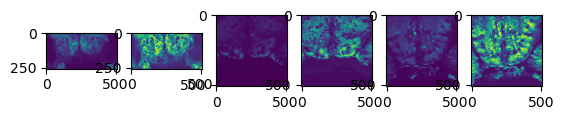

In [23]:
equalized_lm_plane =equalize_adapthist(lm_plane, clip_limit=0.03)
equalized_lm_stack = np.array([equalize_adapthist(slice, clip_limit=0.03) for slice in lm_stack])
fig, axs = plt.subplots(ncols=6)
axs[0].imshow(lm_plane)
axs[1].imshow(equalized_lm_plane)
axs[2].imshow(lm_stack[20])
axs[3].imshow(equalized_lm_stack[20])
axs[4].imshow(lm_stack[120])
axs[5].imshow(equalized_lm_stack[120])

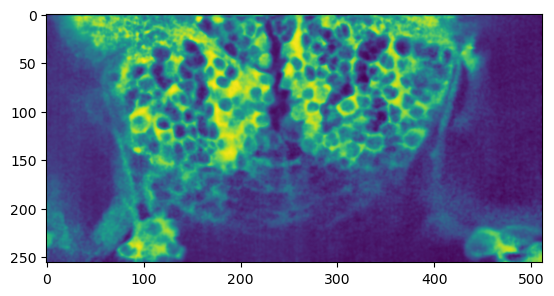

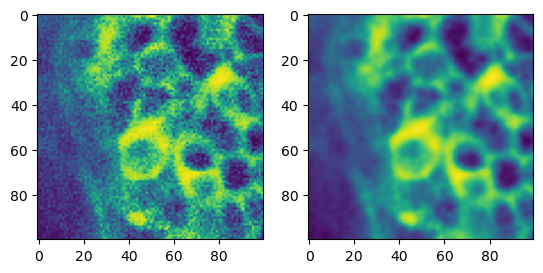

In [10]:
gaussian_equalized_lm_plane = difference_of_gaussians(equalized_lm_plane, low_sigma=1, high_sigma =1000)
plt.imshow(gaussian_equalized_lm_plane)

#gaussian_equalized_lm_stack = np.array([difference_of_gaussians(slice, low_sigma=1, high_sigma =1000) for slice in equalized_lm_stack])

fig, axs = plt.subplots(ncols=2)

axs[0].imshow(equalized_lm_plane[50:150,50:150])
axs[1].imshow(gaussian_equalized_lm_plane[50:150,50:150])


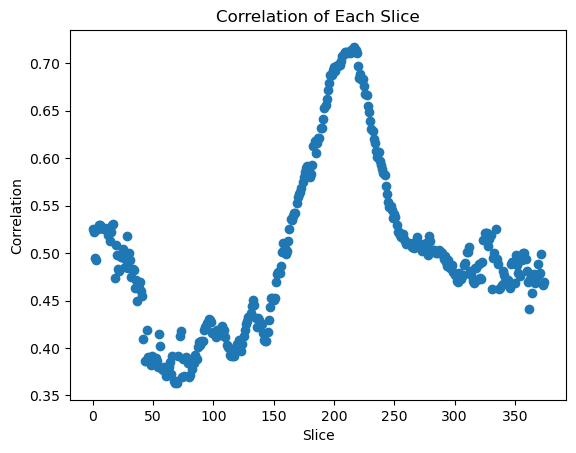

CPU times: total: 38.7 s
Wall time: 38.7 s


In [11]:
%%time
# find coarse slice to plane  
binned_plane = bin_2x2_grayscale(gaussian_equalized_lm_plane)
binned_stack = np.array([bin_2x2_grayscale(slice) for slice in equalized_lm_stack])
max_corr_coarse, max_position_coarse, all_correlations_coarse = find_plane_in_stack(binned_plane, binned_stack, plot_all_correlations= True)



In [12]:
stack = equalized_lm_stack
plane = gaussian_equalized_lm_plane

In [13]:
print(max_position_coarse[0])
z_range = 50
half_z_range = z_range // 2
# Ensure min_z_range is not less than 0 and max_z_range does not exceed stack.shape[0]
min_z_range = max(0, max_position_coarse[0] - half_z_range)
max_z_range = min(stack.shape[0], max_position_coarse[0] + half_z_range)

z_crop = range(min_z_range, max_z_range)

print(z_crop[0], z_crop[-1])

217
192 241


Original image size: 256x512
Tile size: 64x128
Adjusted image size for perfect slicing: 256x512
Number of tiles: 16


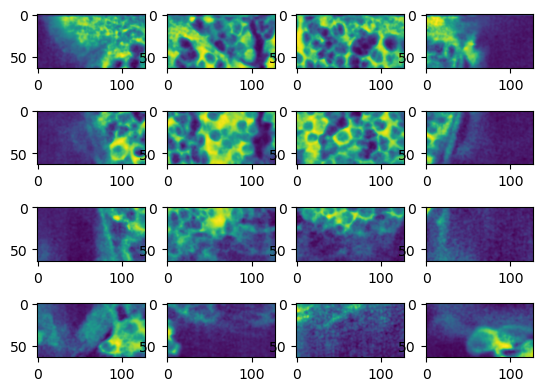

In [14]:
#Define stack and planes to match 
nx, ny = (4, 4)
tiles, tile_size, adj_image_size = slice_into_uniform_tiles(plane, nx, ny, plot=True)
tiles_filter = np.array([[1, 1, 1, 1],
                         [1, 1, 1, 1],
                        [1, 1, 1, 1],
                        [1, 1, 1, 1]])

In [15]:
%%time
best_plane_matrix, all_correlations_matrix = find_best_planes(tiles, stack, tiles_filter, z_range=[z_crop[0], z_crop[-1]])

CPU times: total: 1min 36s
Wall time: 1min 36s


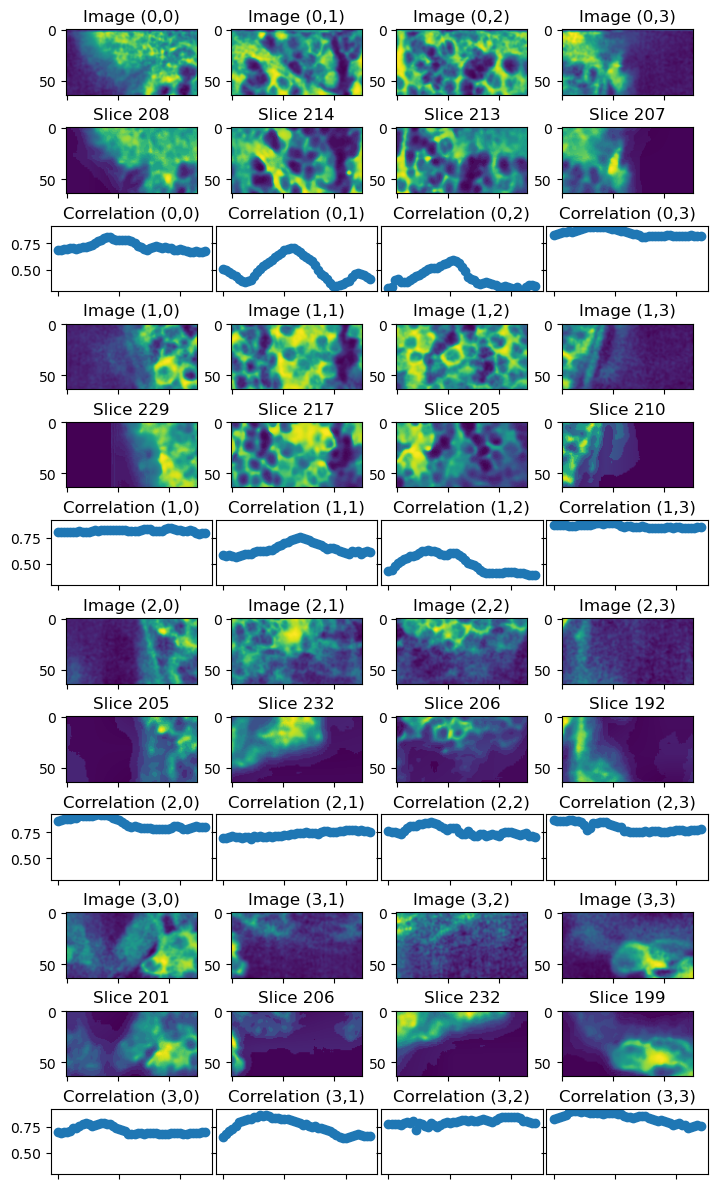

CPU times: total: 13.2 s
Wall time: 13.2 s


In [16]:
%%time
plot_image_correlation(tiles, stack, best_plane_matrix, all_correlations_matrix)

In [17]:
filter_matrix = np.zeros(shape=(nx, ny),dtype=int)
filter_matrix

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

(array([0, 1, 2, 3, 5, 6], dtype=int64),)
[[208 159  77]
 [214 159 196]
 [213 159 316]
 [207 156 432]
 [229  87  20]
 [217 226 199]
 [205 226 316]
 [210 224 438]
 [205 290  72]
 [232 383 120]
 [206 288 318]
 [192 283 441]
 [201 350  69]
 [206 347 195]
 [232 403 102]
 [199 346 448]]
transformed_source [[212.71613522 162.48378455  76.81307352]
 [211.24798102 161.45593923 196.15556143]
 [209.77982683 160.4280939  315.49804934]
 [208.31167264 159.40024858 434.84053726]
 [211.70626924 221.12988954 196.67514527]
 [210.23811505 220.10204421 316.01763319]]
[[-4.71613522 -3.48378455  0.18692648]
 [ 2.75201898 -2.45593923 -0.15556143]
 [ 3.22017317 -1.4280939   0.50195066]
 [-1.31167264 -3.40024858 -2.84053726]
 [ 5.29373076  4.87011046  2.32485473]
 [-5.23811505  5.89795579 -0.01763319]]
Found 170 from 241 centroids 


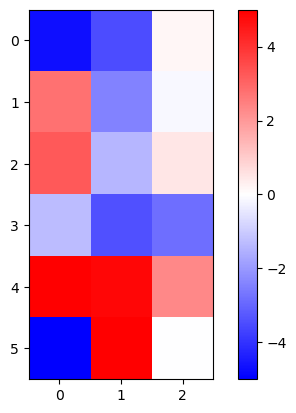

In [18]:
filter_matrix= np.array([[1, 1, 1, 1],
                      [0, 1, 1, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]])
points_filter = np.where(filter_matrix.flatten()==1)
print(points_filter)

# Create registration model  
# lm alignment points
lm_stack_points = np.array([best_plane_matrix[i,j] for i in range(nx) for j in range(ny) ])
print(lm_stack_points)


x = np.arange(tile_size[1]//2, adj_image_size[1], tile_size[1])
y = np.arange(tile_size[0]//2, adj_image_size[0], tile_size[0])
xv, yv = np.meshgrid(x, y)

lm_plane_points = np.array([(0, yv[i,j], xv[i,j])
                            for i in range(ny) for j in range(nx)])

source = lm_plane_points[points_filter]
target = lm_stack_points[points_filter]

# Calculate the transformation
tform = SimilarityTransform()
tform.estimate(source, target)

# Apply the transformation to a new set of points
transformed_source = tform(source)
print(f"transformed_source",transformed_source)
#print("Transformation matrix:")
#print(tform.params)

print(target-transformed_source)
plt.imshow(target-transformed_source, cmap="bwr", vmin = -5, vmax=5)
plt.colorbar()

# Apply transformation to lm plane centroids
transformed_lm_plane_centroids = tform(lm_plane_centroids_3d)

# Find overlay of em warped masks and transformed_lm_plane_centroids
labels_at_coords = ndimage.map_coordinates(
        expanded_em_labels, np.transpose(list(transformed_lm_plane_centroids)), order=0
        )
print(f"Found {np.unique(labels_at_coords[labels_at_coords>0]).shape[0]} from {transformed_lm_plane_centroids.shape[0]} centroids ")

# Filter mask of em warped
filtered_em_mask = np.isin(expanded_em_labels, list(np.unique(labels_at_coords[labels_at_coords>0])))


134
105


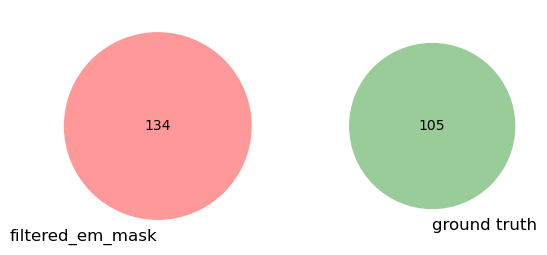

In [366]:
#unique_labels = np.unique(expanded_em_labels[filtered_em_mask])
#print(len(unique_labels))
#gt_unique_labels = np.unique(expanded_em_labels[gt_filtered_em_mask])
#print(len(gt_unique_labels))
#len(set(unique_labels).intersection(gt_unique_labels))

#from matplotlib_venn import venn2

#venn2(subsets = (len(unique_labels), len(gt_unique_labels), len(set(unique_labels).intersection(gt_unique_labels))), set_labels = ('filtered_em_mask', 'ground truth'))
#plt.show()

In [22]:
# Visualize
viewer = napari.Viewer()

# adding plane with mask and centroids
viewer.add_image(plane)
viewer.add_labels(lm_plane_mask)
viewer.add_points(lm_plane_centroids)

#adding lm stack 
viewer.add_image(lm_stack, opacity=0.5)

# adding lm points
viewer.add_points(source, face_color='r')
viewer.add_points(target, face_color='g')

# adding transformed lm points
viewer.add_points(transformed_source, face_color='b')

viewer.add_points(transformed_lm_plane_centroids, face_color='g', size=5, name="SimilarityTransform dataset")
viewer.add_points(lm_plane_centroids_3d, face_color='m')


# adding em warped mask (extended) and its centroids
viewer.add_labels(expanded_em_labels, opacity=0.5, visible=False)
viewer.add_points(lm_stack_centroids)

<Points layer 'lm_stack_centroids' at 0x16b9c99f310>

In [23]:
# adding filtered em mask against ground truth
#viewer.add_image(gt_filtered_em_mask, colormap = "red", opacity = 0.25 )
viewer.add_image(filtered_em_mask, colormap = "red", opacity = 0.25 )

<Image layer 'filtered_em_mask' at 0x16b536c93d0>

In [284]:
tform

<SimilarityTransform(matrix=
    [[ 1.02381212e+00, -1.14263954e-01, -1.80285967e-02,  1.32046857e+02],
     [ 1.14253463e-01,  1.02397076e+00, -1.60123752e-03,  1.33490718e+02],
     [ 1.80949641e-02, -4.08087395e-04,  1.03016743e+00, -1.09650641e+01],
     [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x23d2ca2db80>

In [39]:
# Save
name = "plane1_2half"
save_parent_folder = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\pycpd"
np.save(save_parent_folder+"\\tform_"+name+".npy", tform)
np.save(save_parent_folder+"\\labels_at_coords_"+name+".npy", labels_at_coords)
np.save(save_parent_folder+"\\transformed_source_"+name+".npy", transformed_source)




In [ ]:
%%time
# Warping stack to plane an iterating
name = "plane1_2half"
save_parent_folder = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\pycpd"
tform = SimilarityTransform(np.load(save_parent_folder+"\\tform_"+name+".npy"))


# Iterate and add transformation matrices

In [71]:
all_transformation_matrices.append(tform.params)

all_transformation_matrices

[array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[ 9.32370268e-01,  7.16075339e-03, -1.14699546e-02,
          2.13221068e+02],
        [-7.25980879e-03,  9.32405474e-01, -8.03004159e-03,
          1.33160732e+02],
        [ 1.14075161e-02,  8.11849755e-03,  9.32363187e-01,
          1.68820376e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 1.0039982 ,  0.01374834,  0.02385375, -4.13841003],
        [-0.01398378,  1.00423069,  0.00977583, -0.82554033],
        [-0.02371649, -0.01010427,  1.00404474,  1.02681447],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 9.93864761e-01, -5.23314761e-02, -1.13525322e-02,
         -1.30262981e-01],
        [ 5.22896216e-02,  9.93924002e-01, -3.93726406e-03,
          1.10750826e+00],
        [ 1.15437801e-02,  3.33514256e-03,  9.95233764e-01,
          5.18149983e+00],
        [ 0.00000000e+00,  0.0000

In [72]:
updated_tform = np.linalg.multi_dot(all_transformation_matrices[::-1])
updated_tform

array([[ 9.23250767e-01,  9.03558174e-02, -1.56183671e-02,
         2.15971958e+02],
       [-9.04782538e-02,  9.23346692e-01, -6.68265357e-03,
         1.29599803e+02],
       [ 1.48927068e-02,  8.17303707e-03,  9.27637588e-01,
         2.06305125e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

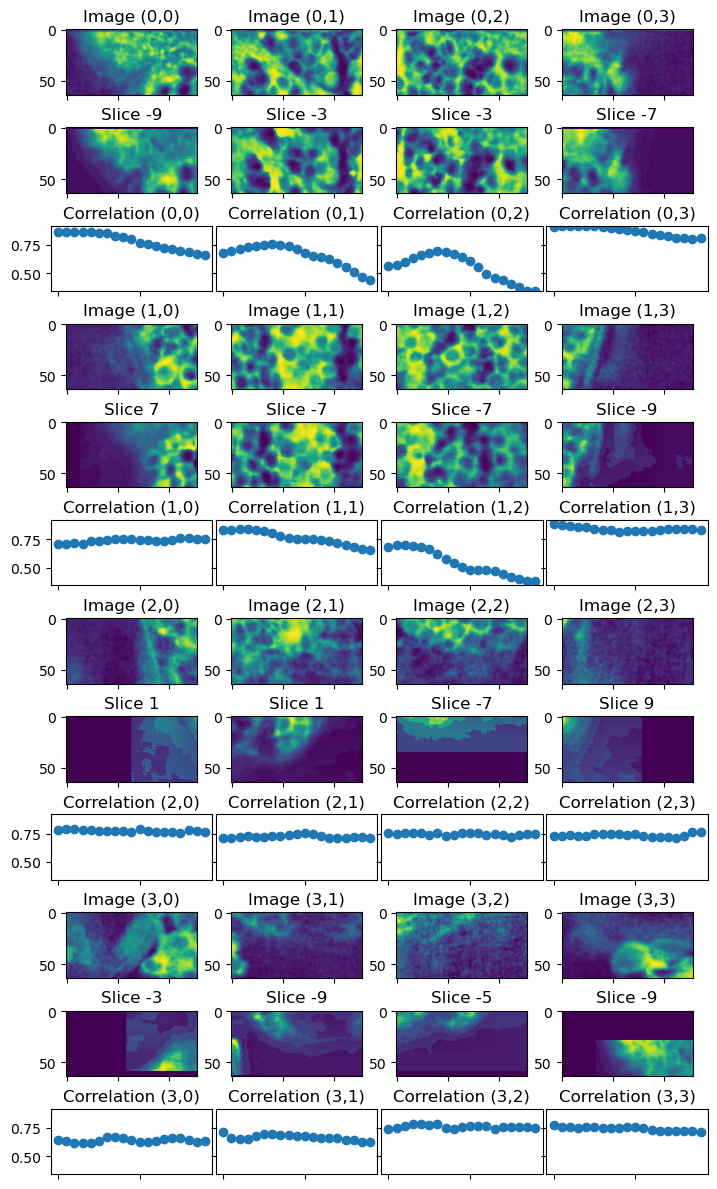

CPU times: total: 33.6 s
Wall time: 33.5 s


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [73]:
%%time
thickness=20
interpolated_stack = warp_stack_to_plane(lm_stack, plane, SimilarityTransform(updated_tform), thickness)
equalized_interpolated_stack = np.array([equalize_adapthist(slice, clip_limit=0.03) for slice in interpolated_stack])

best_plane_matrix, all_correlations_matrix = find_best_planes(tiles, equalized_interpolated_stack, tiles_filter)

plot_image_correlation(tiles, equalized_interpolated_stack, best_plane_matrix, all_correlations_matrix)

filter_matrix = np.zeros(shape=(nx, ny))
filter_matrix

In [75]:
#viewer = napari.Viewer()
#viewer.add_image(stack)

# 2 channel image with original plane in 2nd channel in the center z-plane
both = np.zeros((2,) + interpolated_stack.shape, dtype=interpolated_stack.dtype)

both[0] = interpolated_stack
both[1, interpolated_stack.shape[0]//2] = match_histograms(plane, interpolated_stack[-1])

viewer.add_image(both, channel_axis=0, contrast_limits = [0,5000], name= "Original in center")

[<Image layer 'Original in center [20]' at 0x1f92ff4b910>,
 <Image layer 'Original in center [21]' at 0x1f9a8398eb0>]

source:  [[ 24  32  64]
 [ 24  32 192]
 [ 24  32 320]
 [ 24  32 448]
 [ 24  96 192]
 [ 24  96 320]]
target:  [[ 27  29  68]
 [ 34  26 196]
 [ 33  27 323]
 [ 22  29 452]
 [ 31  96 196]
 [ 32  94 324]]
Transformation matrix:
[[ 1.00157772e+00  3.72616000e-02 -1.06910123e-02  6.54508182e+00]
 [-3.72729685e-02  1.00163398e+00 -8.68970110e-04 -2.13680463e+00]
 [ 1.06513098e-02  1.26588038e-03  1.00227023e+00  2.92901056e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-4.09109356  0.03468263  0.6295554 ]
 [ 4.27735601 -2.8540892   0.33896654]
 [ 4.64580559 -1.74286102 -0.95162231]
 [-4.98574484  0.36836715 -0.24221117]
 [-1.10738639  3.04133613  0.2579502 ]
 [ 1.26106319  1.15256431 -0.03263866]]


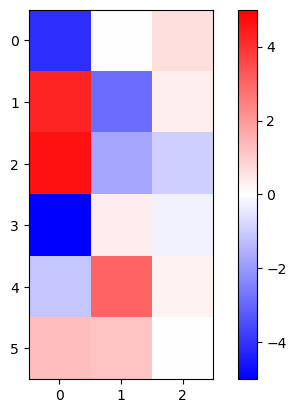

In [70]:
#Select which tiles to believe! 
filter_matrix = np.array([[1., 1., 1., 1.],
                           [0., 1., 1., 0.],
                           [0., 0., 0., 0.],
                           [0., 0., 0., 0.]])

points_filter = np.where(filter_matrix.flatten()==1)

lm_plane_points = np.array([(interpolated_stack.shape[0]//2, yv[i,j], xv[i,j])
                            for i in range(ny) for j in range(nx)])
lm_stack_points = np.array([best_plane_matrix[i,j] for i in range(nx) for j in range(ny) ])

source = lm_plane_points[points_filter]
target = lm_stack_points[points_filter]

print(f"source: ",source)
print(f"target: ",target)

# Calculate the transformation
tform = SimilarityTransform()
tform.estimate(source, target)

# Apply the transformation to a new set of points
transformed_source = tform(source)

print("Transformation matrix:")
print(tform.params)

print(target-transformed_source)
plt.imshow(target-transformed_source, cmap="bwr", vmin = -5, vmax=5)
plt.colorbar()

In [179]:
import csv
# Compare to ground truth
lmks_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\pycpd\landmarks_plane4LM.csv'
# Lists to hold the coordinates
ilm_landmarks = []  # Points from 2P microscopy
alm_landmarks = []  # Corresponding points from EM microscopy

with open(lmks_path, 'r') as file:  # Replace with your CSV file path
    csv_reader = csv.reader(file)
    for row in csv_reader:
        # Assuming the format is: "Pt-0","true",EM_x,EM_y,EM_z,2P_x,2P_y,2P_z
        # (OJO) Here they were converted from um to px and then shifted due to previous cropping!! 
        alm_landmarks.append([float(row[4])/0.4, float(row[3])/0.4, float(row[2])/0.4]) 
        ilm_landmarks.append([0, float(row[6])/0.4, float(row[5])/0.4]) 

# Convert lists to NumPy arrays
ilm_landmarks = np.array(ilm_landmarks)
alm_landmarks = np.array(alm_landmarks)
print(ilm_landmarks)
print(alm_landmarks)

# doing the whole thing before

gt_filtered_em_mask = filtered_em_mask
gt_tform = tform
print(tform)

[[  0.          99.37947208  99.01435152]
 [  0.          98.36985338 295.61114386]
 [  0.          18.25206938  56.86436018]
 [  0.          94.31577626 174.02467929]
 [  0.          19.93983921 179.20325653]
 [  0.          47.41578264 199.46435026]
 [  0.          69.59527713 194.27512061]
 [  0.          71.13585215 279.00674658]
 [  0.          75.36277817 334.8765522 ]
 [  0.          13.64462047 255.07182066]
 [  0.          37.96346586 150.29062262]
 [  0.          12.13379007 349.43517426]
 [  0.          64.29251035 179.42886716]]
[[ 39.89165197 243.94325885  79.92371327]
 [ 30.01471459 241.32048063 291.31648982]
 [ 45.71265446 152.83682587  37.88467827]
 [ 33.80996758 237.22787806 161.86409464]
 [ 36.87135715 156.25513356 165.30225558]
 [ 39.87368375 188.07979543 183.31621513]
 [ 38.37252045 210.89747752 181.21458651]
 [ 35.37019386 212.39864082 274.88717616]
 [ 38.29726166 215.2457954  333.03598619]
 [ 44.62740157 145.82047405 247.70540537]
 [ 44.17151976 178.14760818 135.0

In [12]:
lm_plane_3d = np.zeros(shape= lm_stack.shape)
lm_plane_3d[0,:lm_plane.shape[0]]= lm_plane
#or
lm_plane_3d = np.zeros(shape= (1,lm_plane.shape[0],lm_plane.shape[1]))
                       
lm_plane_3d[0]= lm_plane

lm_plane_mask_3d = np.zeros(shape= (1,lm_plane.shape[0],lm_plane.shape[1]), dtype=int)
                       
lm_plane_mask_3d[0]= lm_plane_mask


In [15]:
lm_plane_3d.shape

(1, 256, 512)

In [360]:
transform.scale

1.0176387942198364

In [363]:
# Adding rotated plane
viewer = napari.Viewer()
viewer.add_image(lm_stack)
viewer.add_labels(lm_plane_mask_3d, translate=transform.translation)


<Labels layer 'lm_plane_mask_3d' at 0x1f20c506c10>

In [364]:
matrix = transform.params.copy()
matrix

array([[ 1.01267867e+00, -1.00036661e-01, -7.95604334e-03,
         1.27320021e+02],
       [ 9.99149831e-02,  1.01261536e+00, -1.46916234e-02,
         1.38304760e+02],
       [ 9.36099595e-03,  1.38388647e-02,  1.01750163e+00,
        -1.01261199e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [ ]:
# Watershed segmentation of LM mask with EM probability map 

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# Generate an initial image with two overlapping circles

image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()


In [291]:
np.save(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\transfer\RMtoTO\lm_plane_centroids_3d.npy",lm_plane_centroids_3d)
np.save(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\transfer\RMtoTO\lm_stack_centroids.npy",lm_stack_centroids)

In [98]:
# Rotating plane with griddata
img = lm_stack[50:100,50:100,50:100]

In [17]:
img.shape

(1, 256, 512)

In [18]:
img_2d = img[0]

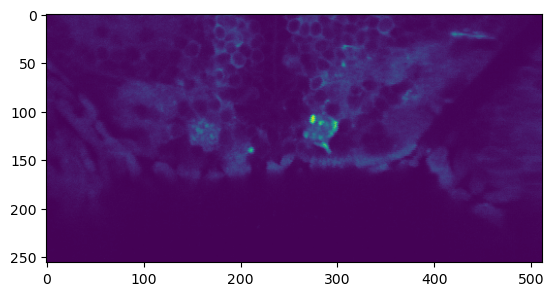

In [19]:
plt.imshow(img_2d)

In [20]:
y, x = np.meshgrid(range(img_2d.shape[0]), range(img_2d.shape[1]), indexing='ij')

In [21]:
points = np.stack([y.flatten(), x.flatten()], axis=1)

In [22]:
points.shape

(131072, 2)

In [23]:
values = img_2d.flatten()
values.shape

(131072,)

In [24]:
from skimage.transform import AffineTransform
transformation = AffineTransform(rotation=np.pi/4)
rotated_points = transformation(points)
rotated_points.shape

(131072, 2)

In [25]:
rotated_points

array([[   0.        ,    0.        ],
       [  -0.70710678,    0.70710678],
       [  -1.41421356,    1.41421356],
       ...,
       [-179.60512242,  540.22958083],
       [-180.3122292 ,  540.93668761],
       [-181.01933598,  541.64379439]])

In [26]:
from scipy.interpolate import griddata

In [27]:
transformed_img = griddata(points, values, rotated_points)

In [28]:
transformed_img.shape = img_2d.shape

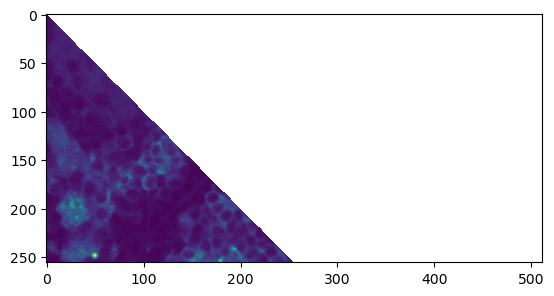

In [29]:
plt.imshow(transformed_img)

The rotation is around the position (0, 0), which is the top-left pixel. To rotate around the center we would have to shift the coordinate systems

In [30]:
points_shifted = points - (img.shape[0]//2, img.shape[1]//2)

In [31]:
rotated_points = transformation(points_shifted)

In [32]:
transformed_img = griddata(points_shifted, values, rotated_points)

In [33]:
transformed_img.shape = img_2d.shape

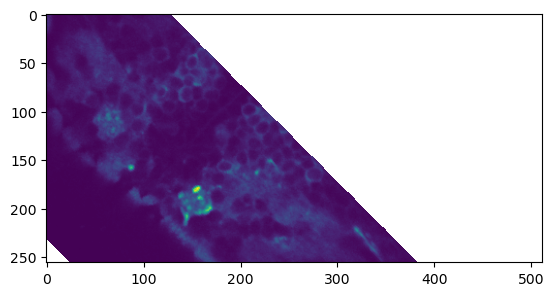

In [34]:
plt.imshow(transformed_img)

Now in 3D

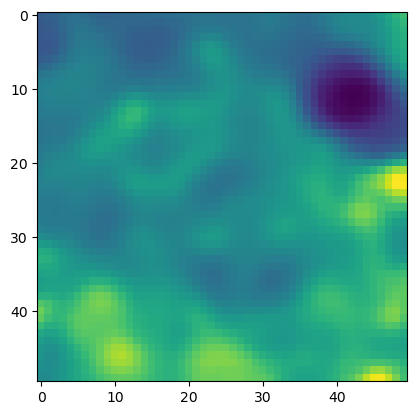

In [128]:
plt.imshow(img[-1])

In [124]:
z, y, x = np.meshgrid(range(img.shape[0]), range(img.shape[1]),range(img.shape[2]), indexing='ij')

In [125]:
points = np.stack([z.flatten(), y.flatten(), x.flatten()], axis=1)

In [126]:
points.shape

(125000, 3)

In [104]:
values = img.flatten()
values.shape

(125000,)

In [83]:
transformation_3d = AffineTransform(rotation=np.pi/4,dimensionality=3)

ValueError: Parameter input is only supported in 2D.

In [106]:
shifted_points = points-(img.shape[0]//2, img.shape[1]//2, img.shape[2]//2)
rotated_points = tform(shifted_points)

In [107]:
transformed_img = griddata(shifted_points, values, rotated_points)

In [ ]:
# Assuming shifted_points and rotated_points are numpy arrays
# Add a small random noise to points to avoid exact duplicates and alignment
noise = np.random.normal(0, 1e-4, shifted_points.shape)
shifted_points_noisy = shifted_points + noise


transformed_img = griddata(shifted_points_noisy, values, rotated_points, method='nearest')

In [94]:
rotated_points, points, shifted_points,shifted_points_noisy

(array([[  75.04387131,    7.91271137, -290.06575564],
        [  75.03706592,    7.9094065 , -289.01531066],
        [  75.03026053,    7.90610163, -287.96486568],
        ...,
        [  28.49048392,  270.61198726,  245.16336778],
        [  28.48367853,  270.60868239,  246.21381276],
        [  28.47687314,  270.60537751,  247.26425774]]),
 array([[  0,   0,   0],
        [  0,   0,   1],
        [  0,   0,   2],
        ...,
        [  0, 255, 509],
        [  0, 255, 510],
        [  0, 255, 511]]),
 array([[   0, -128, -256],
        [   0, -128, -255],
        [   0, -128, -254],
        ...,
        [   0,  127,  253],
        [   0,  127,  254],
        [   0,  127,  255]]),
 array([[ 3.53097762e-05, -1.28000001e+02, -2.55999973e+02],
        [-4.55032829e-05, -1.28000170e+02, -2.54999780e+02],
        [-1.58117866e-05, -1.28000005e+02, -2.54000024e+02],
        ...,
        [ 1.81160823e-05,  1.27000023e+02,  2.52999988e+02],
        [ 1.42588430e-04,  1.26999912e+02,  2.5400

In [108]:
transformed_img.shape

(125000,)

In [109]:
transformed_img.shape = img.shape
transformed_img.shape

(50, 50, 50)

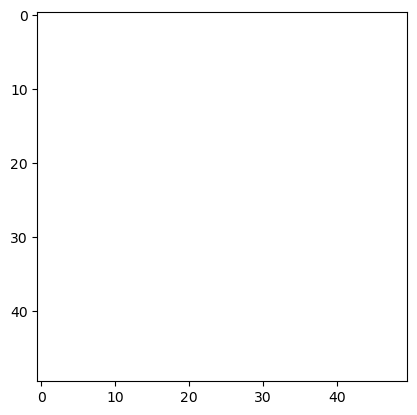

In [119]:
plt.imshow(transformed_img[10])

In [ ]:
plt.imshow(img[10])

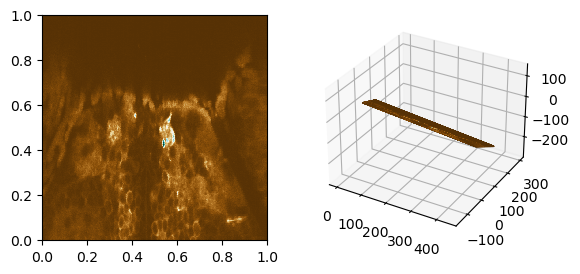

In [169]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create a 21 x 21 vertex mesh
#xx, yy = np.meshgrid(np.linspace(0,1,21), np.linspace(0,1,21))
xx, yy  = np.meshgrid(range(img_2d.shape[0]), range(img_2d.shape[1]), indexing='ij')

# create some dummy data (20 x 20) for the image
#data = np.random.random((20, 20))
data = lm_plane

# create vertices for a rotated mesh (3D rotation matrix)
X = np.sqrt(1./3) * xx + np.sqrt(1./3) * yy
Y = -np.sqrt(1./3) * xx + np.sqrt(1./3) * yy
Z = np.sqrt(1./3) * xx - np.sqrt(1./3) * yy


# create the figure
fig = plt.figure()

# show the reference image
ax1 = fig.add_subplot(121)
ax1.imshow(data, cmap=plt.cm.BrBG, interpolation='nearest', origin='lower', extent=[0,1,0,1])

# show the 3D rotated projection
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.BrBG(data), shade=False)

In [172]:
X.shape

(256, 512)

In [173]:
rotated_points.shape

(125000, 3)

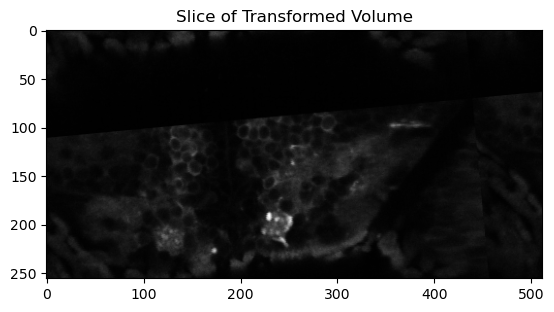

<Image layer 'transformed_volume [7]' at 0x23db28dfd30>

In [198]:
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt

# Assuming lm_volume is your 3D volume data with shape (depth, height, width)
# Example dimensions for demonstration
depth, height, width = lm_plane_3d.shape
lm_volume = lm_plane_3d

# Your 3D transformation matrix
transformation_matrix = np.array(tform)

# Generate the original coordinate grid
z, y, x = np.mgrid[0:depth, 0:height, 0:width]
homogeneous_coordinates = np.vstack([x.ravel(), y.ravel(), z.ravel(), np.ones(z.size)])

# Apply the transformation
transformed_coordinates_homogeneous = transformation_matrix @ homogeneous_coordinates
transformed_coordinates = transformed_coordinates_homogeneous[:3, :]  # Ignore the homogeneous coordinate

# The coordinates for map_coordinates need to be in the shape of (3, ...)
# and need to be transformed back to the original volume's indexing
transformed_coordinates_indices = np.array([
    transformed_coordinates[2, :].reshape(depth, height, width),  # Z-coordinates
    transformed_coordinates[1, :].reshape(depth, height, width),  # Y-coordinates
    transformed_coordinates[0, :].reshape(depth, height, width)   # X-coordinates
])

# Interpolate the transformed volume back to the original grid
# Coordinates passed in the order expected by map_coordinates
transformed_volume = map_coordinates(lm_volume, transformed_coordinates_indices, order=1, mode='grid-wrap')

# Visualization (showing a single slice for simplicity)
plt.imshow(transformed_volume[0], cmap='gray')
plt.title('Slice of Transformed Volume')
plt.show()
viewer.add_image(transformed_volume)


In [199]:

# Step 1: Expand the 2D plane to 3D space
# Creating a grid of points for the 2D plane
height, width = lm_plane.shape
y, x = np.mgrid[0:height, 0:width]
z = np.zeros_like(x) # Adding a third dimension (z) initially set to 0
points_2d = np.stack((x, y, z), axis=-1) # Shape will be (256, 512, 3)

# Step 2: Create a 4x4 transformation matrix
# For demonstration, let's use a simple translation matrix that shifts points along the Z-axis
translation_distance = 10
transformation_matrix = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, translation_distance],
    [0, 0, 0, 1]
])

# Reshaping the points_2d to apply the transformation matrix
points_2d_reshaped = points_2d.reshape(-1, 3)
points_2d_homogeneous = np.hstack((points_2d_reshaped, np.ones((points_2d_reshaped.shape[0], 1)))) # Adding a 1 for homogeneous coordinates

# Step 3: Apply the transformation
points_3d_transformed = points_2d_homogeneous.dot(transformation_matrix.T)

# Checking the shape of the transformed points to confirm the operation
points_3d_transformed.shape


(131072, 4)

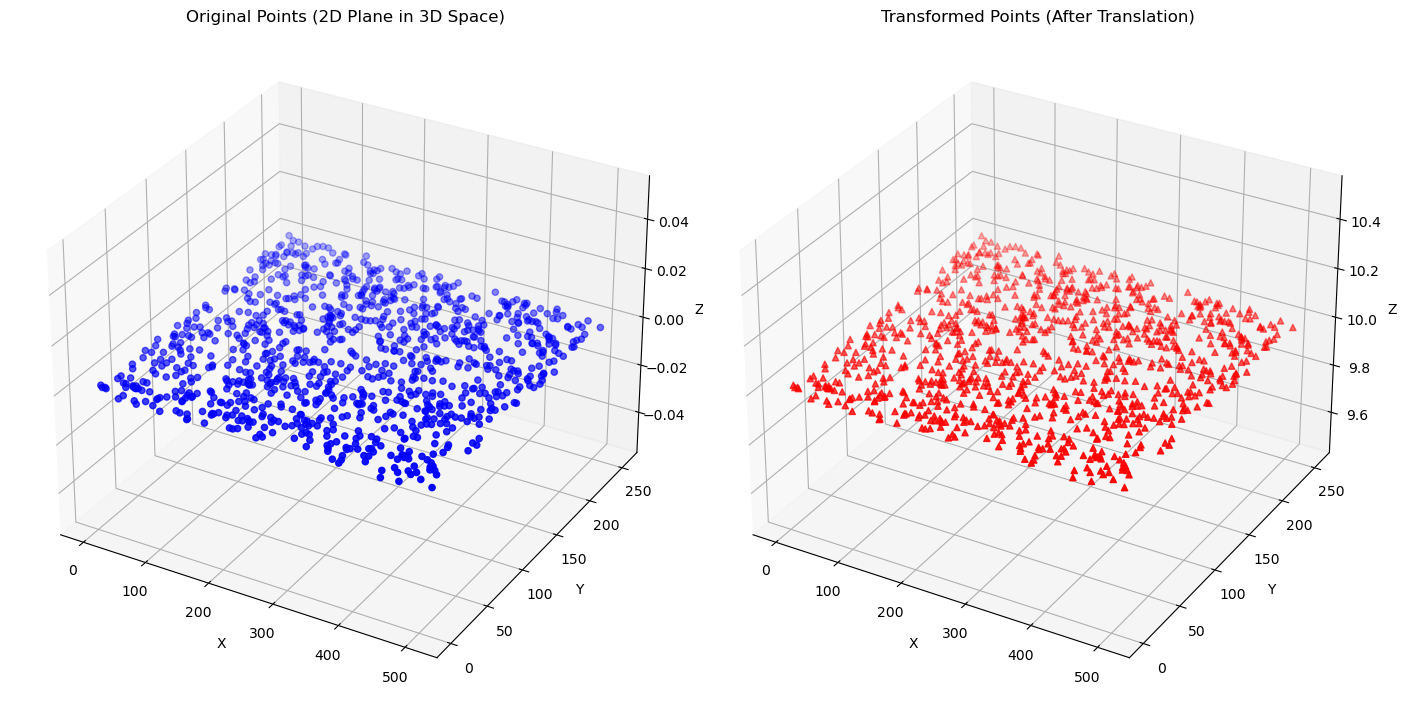

In [200]:
# Re-importing necessary libraries and redefining data for visualization due to reset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Original data setup
height, width = lm_plane.shape
y, x = np.mgrid[0:height, 0:width]
z = np.zeros_like(x)
points_2d = np.stack((x, y, z), axis=-1)

# Transformation matrix and transformation application
translation_distance = 10
transformation_matrix = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, translation_distance],
    [0, 0, 0, 1]
])

points_2d_reshaped = points_2d.reshape(-1, 3)
points_2d_homogeneous = np.hstack((points_2d_reshaped, np.ones((points_2d_reshaped.shape[0], 1))))
points_3d_transformed = points_2d_homogeneous.dot(transformation_matrix.T)
points_3d_transformed_dropped = points_3d_transformed[:, :3]

# Sampling points for visualization
sample_indices = np.random.choice(points_3d_transformed_dropped.shape[0], 1000, replace=False)
points_sampled_original = points_2d_reshaped[sample_indices]
points_sampled_transformed = points_3d_transformed_dropped[sample_indices]

# Plotting
fig = plt.figure(figsize=(14, 7))

# Original points (before transformation)
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points_sampled_original[:, 0], points_sampled_original[:, 1], points_sampled_original[:, 2], c='blue', marker='o')
ax1.set_title('Original Points (2D Plane in 3D Space)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Transformed points (after translation)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_sampled_transformed[:, 0], points_sampled_transformed[:, 1], points_sampled_transformed[:, 2], c='red', marker='^')
ax2.set_title('Transformed Points (After Translation)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()


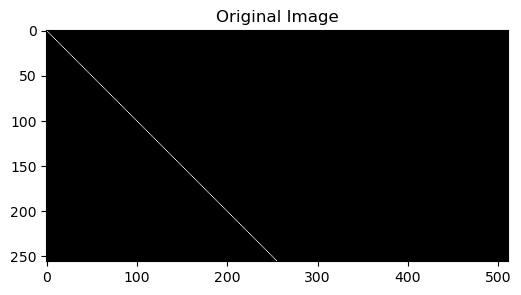

In [201]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a synthetic image for demonstration
# Simple pattern: a diagonal line across the plane
image = np.zeros((256, 512))
np.fill_diagonal(image, 255)

# Display the original image
plt.figure(figsize=(6, 3))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

# Let's assume we want to rotate the image around the Y-axis (vertical axis)
# Define a rotation matrix for a 45-degree rotation around the Y-axis
angle = np.radians(45)  # Convert angle to radians for np.cos and np.sin
rotation_matrix_y = np.array([
    [np.cos(angle), 0, np.sin(angle), 0],
    [0, 1, 0, 0],
    [-np.sin(angle), 0, np.cos(angle), 0],
    [0, 0, 0, 1]
])

# For simplicity in this example, instead of transforming each pixel's position,
# we'll discuss the conceptual approach to apply the transformation to the image.

# The approach involves:
# 1. Mapping each pixel to 3D space (x, y, 0) with homogeneous coordinates (x, y, 0, 1).
# 2. Applying the rotation matrix to these points.
# 3. Projecting the transformed points back onto a 2D plane for visualization.


In [202]:
tform

<SimilarityTransform(matrix=
    [[ 1.06932423e+00, -9.88353099e-02, -1.57206100e-02,  4.83865881e+01],
     [ 9.88090846e-02,  1.06943927e+00, -2.50709394e-03,  1.36403526e+02],
     [ 1.58846112e-02,  1.04986984e-03,  1.07387916e+00, -2.65635800e+01],
     [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x23dc1ce04c0>

In [139]:
# [[ 1.03676995e+00, -1.68978215e-01, -6.80538813e-03,  5.16724804e+01],
 #    [ 1.68959793e-01,  1.03679002e+00, -3.30487294e-03,  1.39775787e+02],
  #   [ 7.24836878e-03,  2.16717392e-03,  1.05044498e+00, -2.08744429e+01],
   #  [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) 

SyntaxError: unmatched ')' (3459276827.py, line 4)

C:\ProgramData\mambaforge\envs\fishpy\lib\site-packages\scipy\interpolate\_interpolate.py:2578: RuntimeWarning: divide by zero encountered in divide
  norm_distances.append((x - grid[i]) /
C:\ProgramData\mambaforge\envs\fishpy\lib\site-packages\scipy\interpolate\_interpolate.py:2557: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


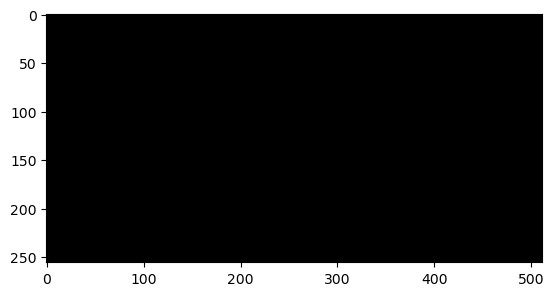

<Image layer 'transformed_img [4]' at 0x23dabb57640>

In [167]:

from scipy.interpolate import RegularGridInterpolator

# Define your transformation matrix here
transformation_matrix = np.array([
    [1.03676995, -0.168978215, -0.00680538813, 51.6724804],
    [0.168959793, 1.03679002, -0.00330487294, 139.775787],
    [0.00724836878, 0.00216717392, 1.05044498, -20.8744429],
    [0.0, 0.0, 0.0, 1.0]
])
transformation_matrix = np.array(tform)
img_3d = lm_plane_3d

# Assuming img_3d is your 3D image with shape (depth, height, width)
depth, height, width = img_3d.shape

# Generate a 3D grid of points
z, y, x = np.mgrid[0:depth, 0:height, 0:width]
points = np.stack([x.flatten(), y.flatten(), z.flatten(), np.ones(x.flatten().shape)], axis=1)  # Note the order and homogeneous coordinates

# Apply the transformation matrix to each point
transformed_points_homogeneous = np.dot(points, transformation_matrix.T)
transformed_points = transformed_points_homogeneous[:, :3] / transformed_points_homogeneous[:, [3]]  # Convert back to 3D coordinates

# Prepare for 3D interpolation
values = img_3d.flatten()
interpolator = RegularGridInterpolator((np.arange(depth), np.arange(height), np.arange(width)), img_3d, bounds_error=False, fill_value=0)

# The new grid to interpolate onto - in this case, it's the same as the original grid
# Note: Depending on the transformation, you might need to adjust this grid
new_z, new_y, new_x = np.mgrid[0:depth, 0:height, 0:width]
new_points = np.stack([new_x.flatten(), new_y.flatten(), new_z.flatten()], axis=1)

# Interpolate
transformed_values = interpolator(transformed_points)
transformed_img = transformed_values.reshape((depth, height, width))

# Visualization (for example, showing a middle slice of the transformed volume)
plt.imshow(transformed_img[depth // 2], cmap='gray')
plt.show() 
viewer.add_image(transformed_img)


In [162]:
shifted_points.shape

(125000, 3)

In [168]:
z.shape, y.shape, x.shape, points.shape

((1, 256, 512), (1, 256, 512), (1, 256, 512), (131072, 4))

In [174]:
from skimage import data, transform
import numpy as np
import matplotlib.pyplot as plt

img = data.camera()

theta = np.deg2rad(10)
tx = 0
ty = 0

S, C = np.sin(theta), np.cos(theta)

# Rotation matrix, angle theta, translation tx, ty
H = np.array([[C, -S, tx],
              [S,  C, ty],
              [0,  0, 1]])

# Translation matrix to shift the image center to the origin
r, c = img.shape
T = np.array([[1, 0, -c / 2.],
              [0, 1, -r / 2.],
              [0, 0, 1]])

# Skew, for perspective
S = np.array([[1, 0, 0],
              [0, 1.3, 0],
              [0, 1e-3, 1]])

img_rot = transform.homography(img, H)
img_rot_center_skew = transform.homography(img, S.dot(np.linalg.inv(T).dot(H).dot(T)))

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax1.imshow(img_rot, cmap=plt.cm.gray, interpolation='nearest')
ax2.imshow(img_rot_center_skew, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

AttributeError: module 'skimage.transform' has no attribute 'homography'

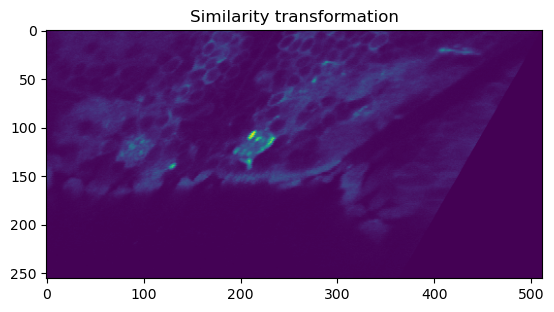

In [178]:
tform = transform.AffineTransform(
        shear=np.pi/6,
        )
tf_img = transform.warp(lm_plane, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('Similarity transformation')

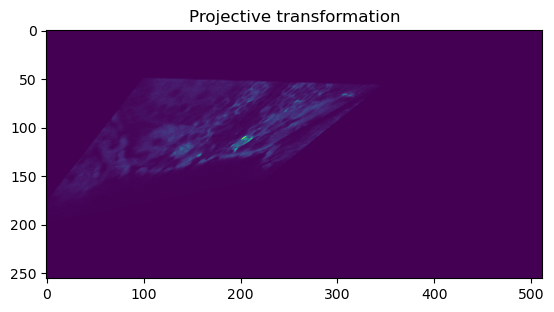

In [182]:
matrix = np.array([[1, -0.5, 100],
                   [0.1, 0.9, 50],
                   [0.0015, 0.0015, 1]])
tform3 = transform.ProjectiveTransform(matrix=matrix)
tf_img = transform.warp(lm_plane, tform3.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
ax.set_title('Projective transformation')

plt.show()

In [ ]:
# Example tuning curve data
stimulus_orientations = np.array([*range(lm_stack.shape[0])])# slices
neural_responses = all_correlations  # Correlations
neural_responses_norm = neural_responses/np.max(neural_responses)

# Calculate mean and standard deviation
mean_response = np.mean(neural_responses)
std_response = np.std(neural_responses)

# Z-score normalization
z_scores = (neural_responses - mean_response) / std_response
# print(z_scores)
neural_responses=z_scores
# Calculate sparseness
sparseness = (np.sqrt(len(neural_responses)) - np.sum(neural_responses) / len(neural_responses)) / (np.sqrt(len(neural_responses)) - 1)

# Calculate selectivity index
pref_response = np.max(neural_responses)
non_pref_response = np.min(neural_responses)
selectivity_index = (pref_response - non_pref_response) / (pref_response + non_pref_response)

print("Sparseness:", sparseness)
print("Selectivity Index:", selectivity_index)


In [8]:


def iterative_alignment(stack, plane, initial_transform, thickness_values):
    """
    Iteratively refines the alignment of a stack to a plane using decreasing thickness values.
    
    Parameters:
    - stack: The 3D image stack to be aligned.
    - plane: The target plane for alignment.
    - initial_transform: The initial transformation to apply to the stack.
    - thickness_values: A list of thickness values for iterative refinement.
    
    Returns:
    - The final, combined transformation after all iterations.
    """
    # Initial transformation matrix stack
    all_transformations = [initial_transform]
    
    # Iterative refinement
    for thickness in thickness_values:
        print(f"Refining alignment with thickness = {thickness}")
        
        # Apply the current transformation and warp the stack
        current_transform = np.linalg.multi_dot(all_transformations[::-1])
        warped_stack = warp_stack_to_plane(stack, plane, SimilarityTransform(current_transform), thickness)
        
        # Perform alignment to update the transformation based on the current warped stack
        # This should be replaced with your actual alignment logic
        new_transform = perform_alignment(warped_stack, plane)
        
        # Update the list of transformations
        all_transformations.append(new_transform.params)
    
    # Combine all transformations into a single transformation
    final_transform = np.linalg.multi_dot(all_transformations[::-1])
    
    return final_transform

stack = lm_stack
plane = lm_plane

# Example usage
thickness_values = [200, 100, 50, 20, 10]
initial_transform = np.eye(4)  # Assuming an identity matrix as the initial transformation
final_transform = iterative_alignment(stack, plane, initial_transform, thickness_values)

# Apply the final transformation to the stack for the final alignment
# This is a placeholder function call; replace with your actual application of the transformation
final_warped_stack = apply_final_transformation(stack, final_transform)


Refining alignment with thickness = 200


ValueError: Expecting at least two arrays.